In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
import scipy.integrate as I
import astropy.units as u

Read in and process dataset for photon flux.

In [8]:
dir = pd.read_csv('./Blackhawk/results//test/photon_primary_spectrum.txt', sep = '    ', skiprows=1)
frag = pd.read_csv('./BlackHawk/results/test/photon_secondary_spectrum.txt', sep = '    ', skiprows=1)

# Stefano's dataset
hardness = pd.read_csv('./Blackhawk/t90_hardness_ratio/hardnessratios.tex', sep='\t')

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [9]:
# 20MeV to 100GeV
LAT_energy = (20 * 1e-3, 300)
# 8 keV to 100MeV
GBM_energy = (200 * 1e-6, 40 * 1e-3)
BGO_energy = (8 * 1e-6, 10 * 1e-3)

In [10]:
dir = dir.set_index('time/energy')
frag = frag.set_index('time/energy')

def generate_lightcurve(dir, frag, energy_range):

    dir = dir.loc[:, (dir.columns.astype('float64') > energy_range[0])]
    dir = dir.loc[:, (dir.columns.astype('float64') < energy_range[1])]

    frag = frag.loc[:, (frag.columns.astype('float64') > energy_range[0])]
    frag = frag.loc[:, (frag.columns.astype('float64') < energy_range[1])]

    lc_dir = [I.simps(x=dir.columns.astype('float64'), y=dir.iloc[i].to_list()) for i in range(dir.shape[0])]

    lc_frag = [I.simps(x=frag.columns.astype('float64'), y=frag.iloc[i].to_list()) for i in range(frag.shape[0])]

    return np.add(lc_dir, lc_frag)


In [11]:
# Define time indices.

# time = [dir.index[0]]
# for i,t in enumerate(dir.index[1:]):
#     time.append(t + time[i])

time = hardness['Time to Death']

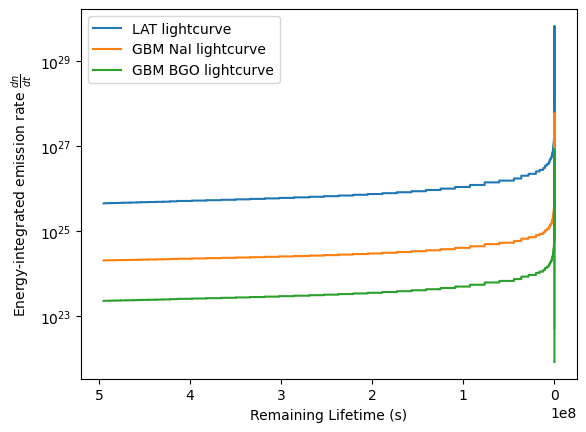

In [12]:
lat_lc = generate_lightcurve(dir, frag, LAT_energy)
gbm_lc = generate_lightcurve(dir, frag, GBM_energy)
bgo_lc = generate_lightcurve(dir, frag, BGO_energy)

d = lambda f, sens = 1e-9: np.sqrt( (1/sens) * u.cm**2 * u.s * f / (4*3.14159) )

lat_d = d(lat_lc/u.s).to('pc')
gbm_d = d(gbm_lc/u.s).to('pc')
bgo_d = d(bgo_lc/u.s).to('pc')

fig, ax = plt.subplots()
#fig, axes = plt.subplots(1, 2, figsize = (12, 5))
###
#ax = axes[0]
ax.step(time, lat_lc, label = 'LAT lightcurve')
ax.step(time, gbm_lc, label = 'GBM NaI lightcurve')
ax.step(time, bgo_lc, label = 'GBM BGO lightcurve')

ax.set_yscale('log')
#ax.set_xscale('log')

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])
ax.legend()

ax.set_ylabel(r'Energy-integrated emission rate $\frac{dn}{dt}$')
ax.set_xlabel('Remaining Lifetime (s)')
fig.savefig('Lightcurves.png', dpi=500)

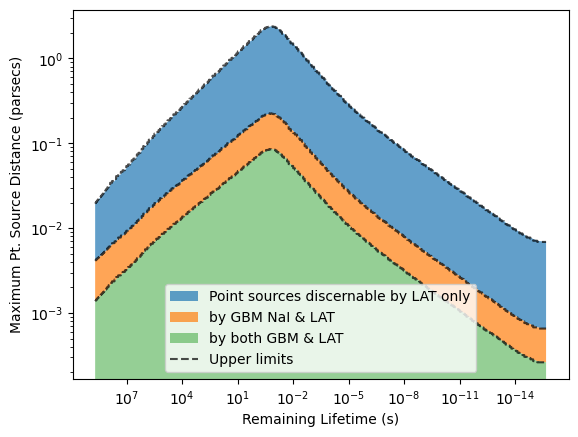

In [100]:
fig, ax = plt.subplots()
#ax = axes[1]
ax.fill_between(time, gbm_d.value, lat_d.value, alpha = 0.7, label = 'Point sources discernable by LAT only')
ax.fill_between(time, y1=bgo_d.value, y2=gbm_d.value, alpha = 0.7, label = 'by GBM NaI & LAT')
ax.fill_between(time, bgo_d.value, alpha=0.5, label = 'by both GBM & LAT')
ax.step( time, lat_d, color = 'black', linestyle='--', alpha = 0.7)# , '-' , label = 'Max distance for photon detection (LAT)')
ax.step( time, gbm_d, color = 'black', linestyle='--', alpha = 0.7, label = 'Upper limits')# , '-' , label = 'Max distance for photon detection (GBM)')
ax.step( time, bgo_d, color = 'black', linestyle='--', alpha = 0.7)
#ax.axhline(0.015, linestyle='-.', color='darkred', label = '0.015 pc', alpha=0.5)

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])

ax.set_ylabel('Maximum Pt. Source Distance (parsecs)')
ax.set_xlabel('Remaining Lifetime (s)')
fig.savefig('DistFuncs.png', dpi=500)

In [337]:
def calculate_inflection_ratio(lightcurve):

    peak_index = list(lightcurve).index(lightcurve.max())

    pre = I.simps(x = time[:peak_index], y = lightcurve[:peak_index])

    post = I.simps(x = time[peak_index:], y = lightcurve[peak_index:])

    return pre, post

for lc in [lat_lc, gbm_lc, bgo_lc]:
    pre, post = calculate_inflection_ratio(lc)
    print('%s / %s = %s'%(pre, post, pre/post))

nan / -8.540696669819566e+28 = nan
nan / -7.505522240374954e+26 = nan
nan / -1.090821970493081e+26 = nan


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:372: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:372: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: invalid value encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: invalid value encountered in add
  y[slice1]*hsum*hsum/hprod +
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7

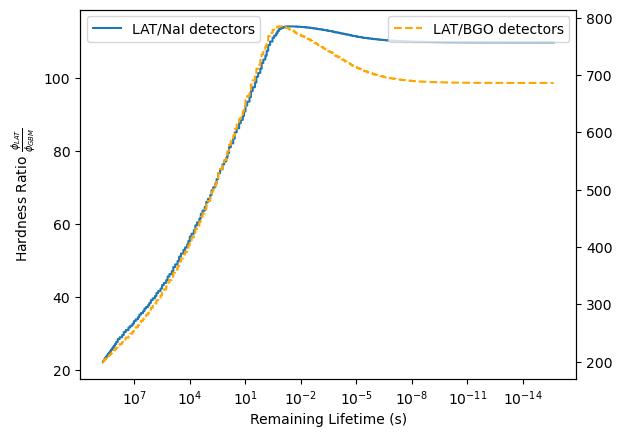

In [342]:
fig, ax = plt.subplots()

ax.step(time, np.divide(lat_lc,gbm_lc), label = 'LAT/NaI detectors')
ax2 = ax.twinx()
ax2.step(time, np.divide(lat_lc,bgo_lc), label = 'LAT/BGO detectors', color = 'orange', linestyle='--')

ax.set_xscale('log')
#ax.set_yscale('log')

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])

ax.legend()
ax2.legend()
ax.set_ylabel(r'Hardness Ratio $\frac{\phi_{LAT}}{\phi_{GBM}}$')
ax.set_xlabel('Remaining Lifetime (s)')
fig.savefig('Hardness.png', dpi = 500)

[Finding T90s](#T90)

In [294]:
# We know that the T90 for an EBH is bounded to the right by a sharp cutoff.
# So the left-bound is the time for 10% of total flux.

# Algorithm:
# for each distance d
#   The flux interval is bounded by the index of d
#   Integrate for the total flux
#   for each time t
#       if integrate from initial time to t  > 0.1*total flux
#   T90 = remaining time at t break - final time

sens = 10**-9 /u.s /u.cm**2

lat_d = d(lat_lc/u.s).to('pc')
gbm_d = d(gbm_lc/u.s).to('pc')
bgo_d = d(bgo_lc/u.s).to('pc')

def calculate_t90(distance, lightcurve):
    t90 = []
    for dist in distance[np.where(time>0.1)]: # All distances corresponding to >1ms of remaining BH lifetime
        
        # Min flux at a given distance to be detected is \phi = sens * 4pi d^2
        minimum_flux = 4 * 3.14159 * dist.to('cm').value**2 * sens.value # ends up being /s
        interval = np.where(lightcurve > minimum_flux)[0] # Only integrate flux exceeding minimum flux required

        if interval.shape[0] != 0: # As long as the flux is at all visible.
            flux_at_distance = lightcurve/(4*3.14159 *dist.to('cm')**2) # Inverse square law

            total_flux = I.simps(x = time[interval], y = flux_at_distance[interval]) # Total flux -- the T90 is the threshold for 10% of this value
            
            # Iterate over the available interval and find the 10% threshold
            i = 0 # Record what interval we break at
            cum_flux = 0. # Flux we're evaluating
            while cum_flux < 1e-1*total_flux: # Break if the cumulative flux is 10% of total
                # Technically I could make this O(N) by coding the integration myself, but this runs fast enough
                cum_flux = I.simps(x = time[interval[:i+1]], y = flux_at_distance[interval[:i+1]]) # This is the partial flux on the limited interval
                i+=1

            t90.append(time[interval[i]] - time[interval[-1]]) # Remaining lifetime - beg. of interval
        else:
            t90.append(0.)

    return t90, distance[np.where(time>0.1)]
    
lat_t90, lat_d_range = calculate_t90(lat_d, lat_lc)
gbm_t90, gbm_d_range = calculate_t90(gbm_d, gbm_lc)
bgo_t90, bgo_d_range = calculate_t90(bgo_d, bgo_lc)



/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:372: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:372: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: invalid value encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/scipy/integrate/_quadrature.py:374: RuntimeWarning: invalid value encountered in add
  y[slice1]*hsum*hsum/hprod +
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7

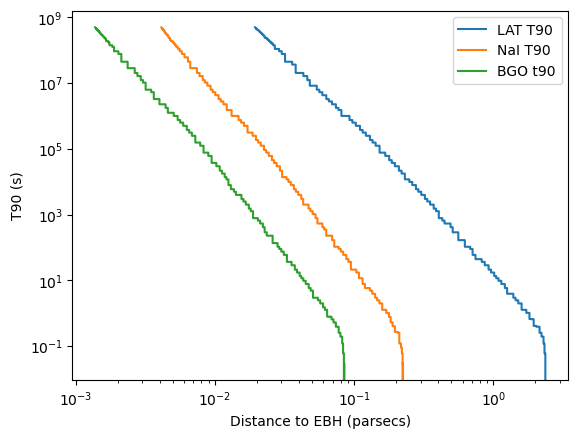

In [341]:
fig, ax = plt.subplots()
ax.step(lat_d_range, lat_t90, label = 'LAT T90')
ax.step(gbm_d_range, gbm_t90, label = 'NaI T90')
ax.step(bgo_d_range, bgo_t90, label = 'BGO t90')
#plt.axvline(0.015, color = 'black', linestyle='dashed', alpha=0.5, label = '0.015 pc')

ax.set_xlabel('Distance to EBH (parsecs)')
ax.set_ylabel('T90 (s)')

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

fig.savefig('T90s.png', dpi=500)

--------

In [60]:
from scipy.optimize import curve_fit

plaw = lambda x,N,index,offset,interc: N*((x-offset)**index) + interc

lat_lc = generate_lightcurve(dir, frag, LAT_energy)
gbm_lc = generate_lightcurve(dir, frag, GBM_energy)
bgo_lc = generate_lightcurve(dir, frag, BGO_energy)

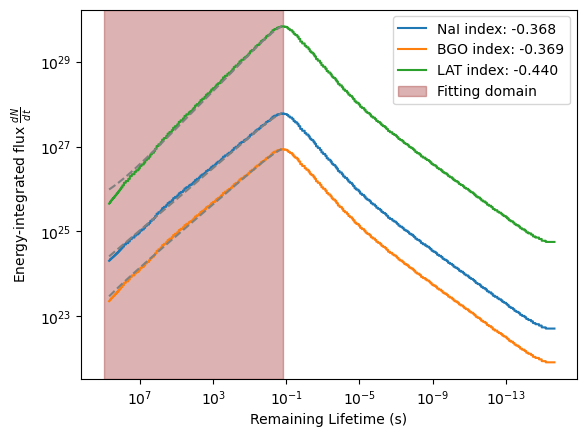

In [90]:
time_max = 1e9

fig, ax = plt.subplots()

### GBM NaI
filter = np.where(time[:list(gbm_lc).index(gbm_lc.max())] < time_max)[0]
ydata = gbm_lc[filter]
xdata = time[filter]
 
params, cov = curve_fit( xdata = xdata, ydata = ydata, f = plaw,
   p0 = [1e29, -0.52, 0, 1e29], bounds = (-np.inf, np.inf))

ax.step(time, gbm_lc, label = 'NaI index: %.3f'%params[1])
ax.plot(xdata, plaw(xdata, *params), '--', color = 'grey')

### GBM BGO
filter = np.where(time[:list(bgo_lc).index(bgo_lc.max())] < time_max)[0]
ydata = bgo_lc[filter]
xdata = time[filter]
 
params, cov = curve_fit( xdata = xdata, ydata = ydata, f = plaw,
   p0 = [1e29, -0.52, 0, 1e29], bounds = (-np.inf, np.inf))

ax.step(time, bgo_lc, label = 'BGO index: %.3f'%params[1])
ax.plot(xdata, plaw(xdata, *params), '--', color = 'grey')

### LAT
filter = np.where(time[:list(lat_lc).index(lat_lc.max())] < time_max)[0]
ydata = lat_lc[filter]
xdata = time[filter]
 
params, cov = curve_fit( xdata = xdata, ydata = ydata, f = plaw,
   p0 = [1e29, -0.52, 0, 1e29], bounds = (-np.inf, np.inf))

ax.step(time, lat_lc, label = 'LAT index: %.3f'%params[1])
ax.plot(xdata, plaw(xdata, *params), '--', color = 'grey')


ax.axvspan(time[list(lat_lc).index(lat_lc.max())], time_max, color = 'darkred', alpha = .3, label = 'Fitting domain')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])


ax.set_ylabel(r'Energy-integrated flux $\frac{dN}{dt}$')
ax.set_xlabel('Remaining Lifetime (s)')

fig.savefig('FitPowerlaw_ranges.png',dpi=500)

----

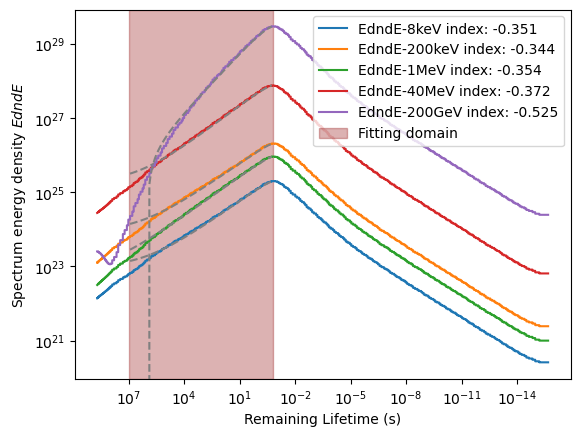

In [91]:
time_max = 1e7

fig, ax = plt.subplots()

for energy_bin in ['EdndE-8keV', 'EdndE-200keV', 'EdndE-1MeV', 'EdndE-40MeV', 'EdndE-200GeV']:
    lc = hardness[energy_bin]
    filter = np.where(time[:list(lc).index(lc.max())] < time_max)[0]
    ydata = lc[filter]
    xdata = time[filter]
    
    params, cov = curve_fit( xdata = xdata, ydata = ydata, f = plaw,
    p0 = [1e29, -0.52, 0, 1e29], bounds = (-np.inf, np.inf))

    ax.step(time, hardness[energy_bin], label = '%s index: %.3f'%(energy_bin,params[1]))
    ax.plot(xdata, plaw(xdata, *params), '--', color = 'grey')

ax.axvspan(time[list(lat_lc).index(lat_lc.max())], time_max, color = 'darkred', alpha = .3, label = 'Fitting domain')

# ax.step(hardness['Time to Death'], hardness['EdndE-8keV'], label = '8keV')
# ax.step(hardness['Time to Death'], hardness['EdndE-200keV'], label = '200keV')
# ax.step(hardness['Time to Death'], hardness['EdndE-1MeV'], label = '1MeV')
# ax.step(hardness['Time to Death'], hardness['EdndE-40MeV'], label = '40MeV')
# ax.step(hardness['Time to Death'], hardness['EdndE-200GeV'], label = '200GeV')

#plt.xlim(1e5,1e-3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

lims = ax.get_xlim()
ax.set_xlim(lims[1], lims[0])

ax.set_ylabel(r'Spectrum energy density $EdndE$')
ax.set_xlabel('Remaining Lifetime (s)')

fig.savefig('FitPowerlaw_energies.png',dpi=500)